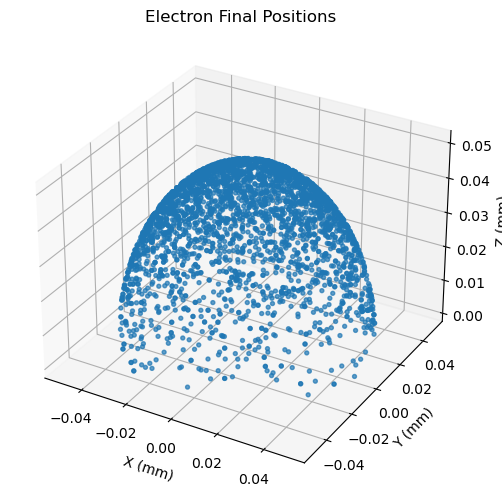

In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
file = '00_iteration0_num10000'
file_path = f"/storage/home/hcoda1/1/kgandhi63/r-zjiang33-0/Grain-Charging-Simulations/build/root/{file}.root"
tree_name = "Hit Data"
KE_TOL = 1e-9

with uproot.open(file_path) as file:
    tree = file[tree_name]

    positions = tree["Post_Step_Position_mm"].array(library="np")  
    volume_name = tree["Volume_Name_Post"].array(library="np")
    kinetic_energy = tree["Kinetic_Energy_Post_MeV"].array(library="np")
    particle_type = tree["Particle_Type"].array(library="np")

if np.issubdtype(volume_name.dtype, np.bytes_):
    volume_name = np.char.decode(volume_name, "utf-8")
if np.issubdtype(particle_type.dtype, np.bytes_):
    particle_type = np.char.decode(particle_type, "utf-8")

mask = (
    (volume_name == "G4_SILICON_DIOXIDE") &
    (particle_type == "e-") &
    (np.isclose(kinetic_energy, 0.0, atol=KE_TOL))
)

coords = np.vstack(positions[mask])

x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]

# Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(x, y, z, s=8, alpha=0.7)

ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_zlabel("Z (mm)")
ax.set_title("Electron Final Positions")

plt.show()

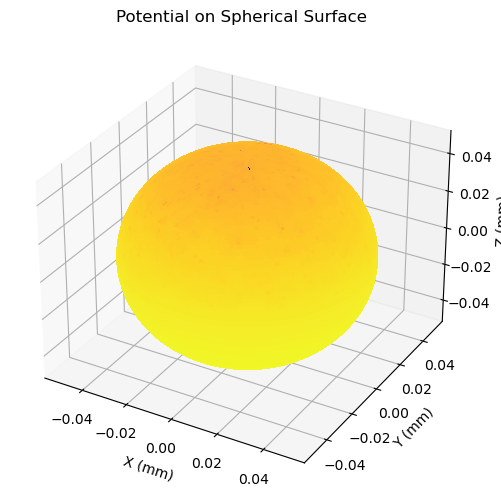

In [3]:
from scipy.constants import epsilon_0, e as q_e
import numpy as np
import matplotlib.pyplot as plt

coords_m = coords * 1e-3

R = np.linalg.norm(coords_m, axis=1).max()

n_theta = 100  # polar angle divisions
n_phi = 200    # azimuthal divisions

theta = np.linspace(0, np.pi, n_theta)
phi = np.linspace(0, 2*np.pi, n_phi)
theta_grid, phi_grid = np.meshgrid(theta, phi)

x_s = R * np.sin(theta_grid) * np.cos(phi_grid)
y_s = R * np.sin(theta_grid) * np.sin(phi_grid)
z_s = R * np.cos(theta_grid)
sphere_points = np.column_stack([x_s.ravel(), y_s.ravel(), z_s.ravel()])

K = 1.0 / (4.0 * np.pi * epsilon_0 * 3.9)  # eps_r=3.9 for SiO2
q = -q_e
V_sphere = np.zeros(sphere_points.shape[0])

for i, p in enumerate(sphere_points):
    r_vec = coords_m - p
    r = np.linalg.norm(r_vec, axis=1)
    V_sphere[i] = K * q * np.sum(1.0 / r)

V_sphere_grid = V_sphere.reshape(theta_grid.shape)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(
    x_s*1e3, y_s*1e3, z_s*1e3,  # back to mm for display
    facecolors=plt.cm.plasma((V_sphere_grid - V_sphere_grid.min()) /
                              (V_sphere_grid.max() - V_sphere_grid.min())),
    rstride=1, cstride=1, antialiased=False, shade=False
)
ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_zlabel("Z (mm)")
ax.set_title("Potential on Spherical Surface")
plt.show()